In [1]:
# Import necessery packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly.io as pio
pio.kaleido.scope.default_width = 1000
pio.kaleido.scope.default_height = 500

In [2]:
#import original CSV
orig_dataset=pd.read_csv(r'X.csv')

In [3]:
#Simple transformations
orig_dataset["file_date"] = pd.to_datetime(orig_dataset["file_date"], errors='coerce')
orig_dataset['no_participants']=orig_dataset['no_participants'].astype('str').apply(lambda x: x.replace(',',''))
orig_dataset=orig_dataset.set_index('file_date')

In [4]:
#Create new dataset based on original data
from sdv.tabular import GaussianCopula
model = GaussianCopula()
model.fit(orig_dataset)

In [5]:
# Making sure that the dimension is the same as original
sample = model.sample(num_rows=len(orig_dataset),randomize_samples=False)
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189 entries, 0 to 1188
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   no_participants  1189 non-null   object
dtypes: object(1)
memory usage: 9.4+ KB


In [6]:
# Transoformations
sample['no_participants']=sample['no_participants'].astype('str').apply(lambda x: x.replace(',','')).astype(int)
sample['index']=orig_dataset.index
sample["index"] = pd.to_datetime(sample["index"], errors='coerce')
sample['month']=sample['index'].dt.to_period('M')
sample=sample.set_index('index')

In [7]:
sample.head(5)

,no_participants,month
index,,
2019-01-01,1020,2019-01
2019-01-02,1698,2019-01
2019-01-03,1013,2019-01
2019-01-04,1347,2019-01
2019-01-05,809,2019-01


In [8]:
# New dataset with aggregated measures (monthly)
dataset=pd.DataFrame()
dataset['prc_diff']=sample.groupby('month').sum().pct_change(periods=1)
dataset['std']=sample.groupby('month')['no_participants'].std()
dataset['mean']=sample.groupby('month')['no_participants'].mean()
dataset['no_participants']=sample.groupby('month')['no_participants'].sum()


<AxesSubplot:xlabel='month'>

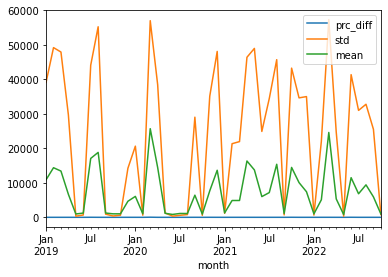

In [9]:
# Plot measures without no_participants
dataset.loc[:, dataset.columns != 'no_participants'].groupby('month').sum().plot(kind='line')

In [10]:
dataset.sample(5)

,prc_diff,std,mean,no_participants
month,,,,
2020-01,0.383927,20619.307089,6061.764706,103050
2019-07,12.878392,44080.021548,17068.687500,273099
2022-05,-0.847196,295.890757,788.161290,24433
2019-12,3.905593,14216.948552,4653.875000,74462
2022-10,-0.883377,784.690303,966.850000,19337


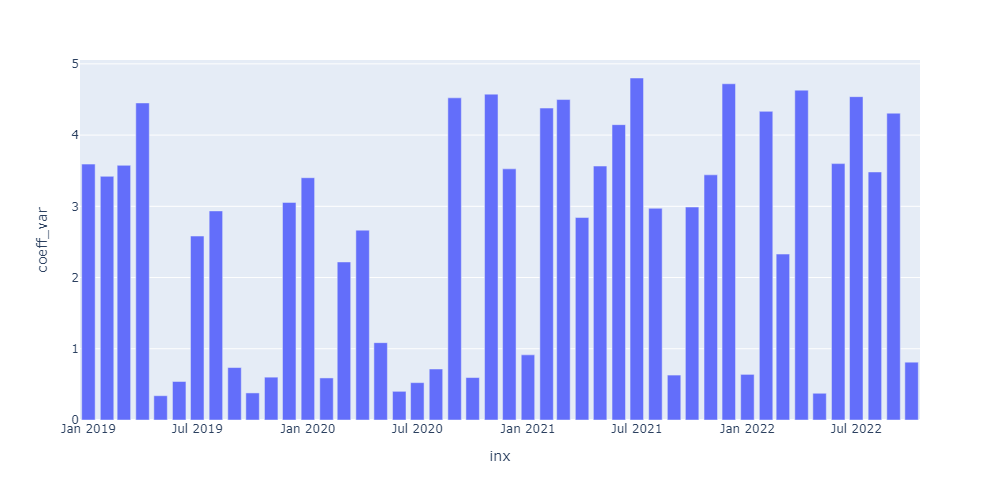

In [11]:
# Calculate and plot Coefficient of Variation
dataset['inx']=dataset.index.astype(str)
dataset['inx']=pd.to_datetime(dataset['inx'],errors='coerce')
dataset['inx'].dtype
dataset['coeff_var']=(dataset['std']/dataset['mean'])
fig = px.bar(dataset, x=dataset.inx, y=dataset.coeff_var,   width=1000, height=500)
fig.show("png")

In [12]:
# Create a threshold of 1.5 mean CV value to spot inkoherent months and transforming index as datatime for plotting purpouses
threshold = round(1.5*dataset['coeff_var'].mean(),2)
dataset['cv_flag'] = dataset['coeff_var'] >threshold
dataset['cv_flag']=dataset['cv_flag'].astype(int)


In [13]:
dataset.sample(2)

,prc_diff,std,mean,no_participants,inx,coeff_var,cv_flag
month,,,,,,,
2022-04,-0.790227,24682.692948,5329.933333,159898,2022-04-01,4.630957,1
2020-01,0.383927,20619.307089,6061.764706,103050,2020-01-01,3.401535,0


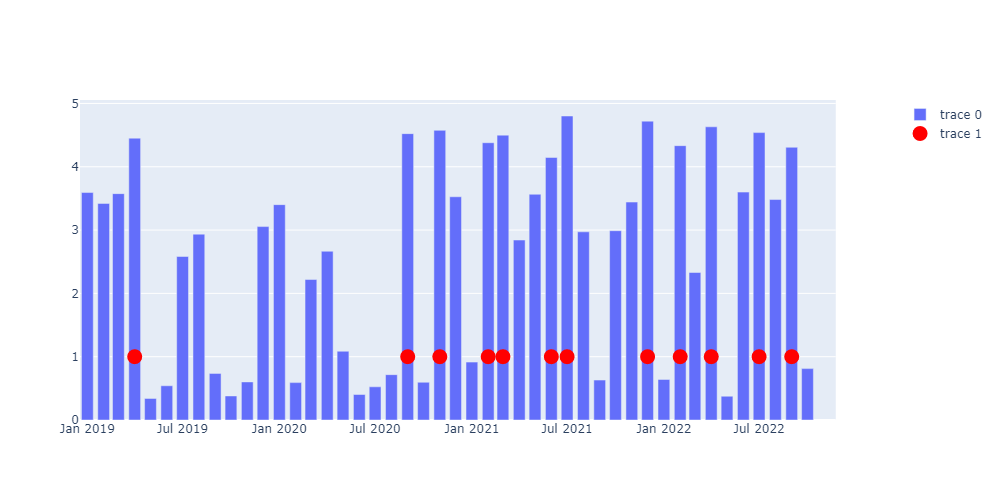

In [14]:
# Visualize non-cohherent and cohherent months flagged by CV

bars = go.Bar(y= dataset.coeff_var, x =dataset.inx,  orientation='v')

line = go.Scatter(y= dataset.query('cv_flag==1').cv_flag,
                  x= dataset.query('cv_flag==1').inx,
                  mode= 'markers',marker=dict(
            size=10,color='red', 
            line=dict(width=5,color="red")))
fig = make_subplots(specs=[[{"secondary_y": True}]], print_grid=False)
fig.add_trace(bars, 1, 1, secondary_y=False)
fig.add_trace(line, 1, 1, secondary_y=False)
fig.update_layout(yaxis2= dict(fixedrange= True,
                                                      range= [0, 1],
                                                      visible= False,))
fig.show("png")

In [15]:
# Compare flagged months with normal
print("Non-cohherent months mean CV is:"+str((dataset.query('cv_flag==1').coeff_var.mean())),'\n'
'Cohherent months mean CV is:' + str(dataset.query('cv_flag==0').coeff_var.mean()))


Non-cohherent months mean CV is:4.492297595033075 
Cohherent months mean CV is:1.9436391734619585


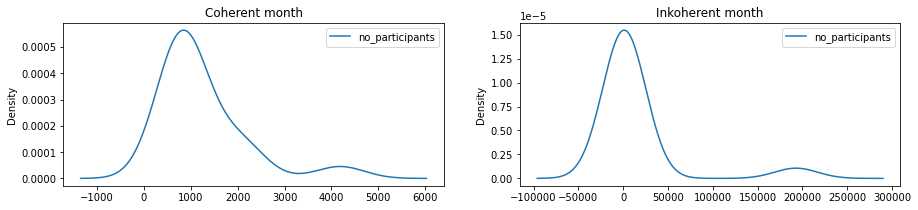

In [16]:
# Plot sample incohherent vs cohherent months
plt.rcParams["figure.figsize"] = (15,3)
x= sample[sample['month']=='2019-03']
y= sample[sample['month']=='2019-09	']
fig, axes = plt.subplots(nrows=1, ncols=2)
x.plot(ax=axes[1],kind='density')
y.plot(ax=axes[0],kind='density')
axes[1].title.set_text('Inkoherent month')
axes[0].title.set_text('Coherent month')

In [17]:
# Calculate Forecasted Proportional Index

dataset['no_days']=sample.groupby('month').count()

def FPI (df,no_participants):
    """"
    Calculating Forecatsted Proportional Index
    
    Args: 
    df (Pandas DataFrame): dataframe with dataset
    no_participants (df collumn): collumn with number of panelists for each month
    
      Returns:
    pandas DataFrame: the values as FPI
    """
    df['proportion']=df[no_participants]/df['no_days']*(df['no_days']).shift(periods=1).fillna(0).astype(int)
    df['FPI']=abs(df[no_participants]-df['proportion'])
    return FPI

In [18]:
# Flag the months above FPI threshold of 1.5 * X
FPI(dataset,'no_participants')
dataset=dataset.iloc[1:]
threshold_FPI = round(1.5*(dataset['FPI'].mean()))
dataset['fpi_flag'] = (dataset['FPI'] >threshold_FPI).astype(int)
dataset.query('fpi_flag==1')['no_participants'].count(),dataset.query('fpi_flag==0')['no_participants'].count()

(7, 38)

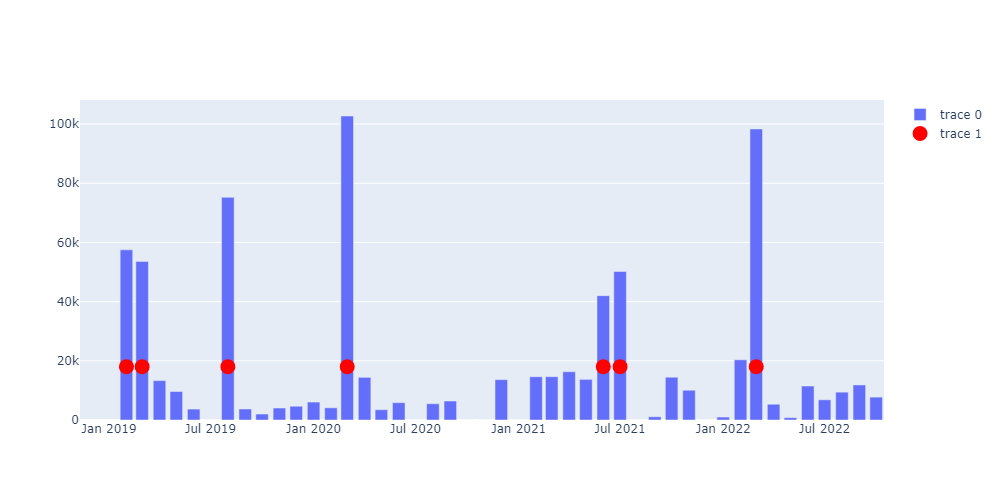

In [19]:
# Visualize non-cohherent and cohherent months flagged by CV
bars = go.Bar(y= dataset.FPI, x =dataset.inx,  orientation='v',showlegend=True)

line = go.Scatter(y= dataset.query('fpi_flag==1').cv_flag+18000,
                  x= dataset.query('fpi_flag==1').inx,
                  mode= 'markers',marker=dict(
            size=10,color='red',
            line=dict(width=5,color="red")))
fig = make_subplots(specs=[[{"secondary_y": False}]], print_grid=False)
fig.add_trace(bars, 1, 1, secondary_y=False)
fig.add_trace(line, 1, 1, secondary_y=False)
fig.update_layout(yaxis2= dict(fixedrange= True,
                                                      range= [0, 1],
                                                      visible= False))
fig.show("png")

In [20]:
# Compare flagged months with normal
print("Non-cohherent months mean no participants is:"+str(round(dataset.query('fpi_flag==1').no_participants.mean())),'\n'
'Cohherent months mean no participants is:'+ str(round(dataset.query('fpi_flag==0').no_participants.mean())))


Non-cohherent months mean FPI is:392103 
Cohherent months mean FPI is:159492
